<a href="https://colab.research.google.com/github/marianasod/xp_projeto_pratico/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from transformers import pipeline
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from google.colab import files
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

##Leitura dos modelos do Hugging Face

In [ ]:

# Usa um modelo pré-treinado de Hugging Face para análise de sentimentos
model_1 = pipeline("sentiment-analysis",  model="cardiffnlp/twitter-xlm-roberta-base-sentiment")
model_2 = pipeline('sentiment-analysis', model='lxyuan/distilbert-base-multilingual-cased-sentiments-student')
model_3 = pipeline('sentiment-analysis', model='citizenlab/twitter-xlm-roberta-base-sentiment-finetunned')

##Funções

In [ ]:
def preprocess_text(text):
    """
    Função para pré-processar o texto

    Parâmetros:
    text (str): Texto a ser pré-processado
    """
     # Remove números
    text = re.sub(r'\d+', '', text)
    # Converte o texto para minúsculas
    text = text.lower()
    # Remove pontuações
    text = re.sub(r'[^\w\s]', '', text)
    # Remove símbolos específicos e pontuações
    text = re.sub(r'[!@#%$&*º\'\"/]', '', text)
    # Remove espaços em branco extras
    text = text.strip()
    return text

def remove_text(df:pd.DataFrame, text:str):
   """
   Função para remover texto específico de um dataframe

   Parâmetros:
   df (pd.DataFrame): Dataframe a ser processado
   text (str): Texto a ser removido
   """
   texto_especifico = ['processo seletivo', "curso", "cursos", "inscrição", "sindicato", "Sindicato"]
   df_filtrado = df
   for t in texto_especifico:
      df_filtrado = df_filtrado[~df_filtrado[text].str.contains(t, case=False, na=False)]
   return df_filtrado

# Função para aplicar a análise de sentimentos em cada texto
def analisar_sentimento(texto):
    """
    Função para analisar o sentimento de um texto

    Parâmetros:
    texto (str): Texto a ser analisado
    """
    resultado = sentiment_analysis(texto)[0]
    return resultado['label'], resultado['score']

def analisar_sentimento_model(model, texto):
    """
    Função para analisar o sentimento de um texto

    Parâmetros:
    texto (str): Texto a ser analisado
    """
    resultado = model(texto)[0]
    return resultado['label'], resultado['score']

def resumo_sentimentos_data(df:pd.DataFrame, groupped_data: list):
    """
    Função para contar a frequência de cada sentimento em um determinado dia.

    Parâmetros:
    df (DataFrame): DataFrame contendo os dados.
    groupped_data (list): Coluna contendo a data de referência.
    sentimento (str): Sentimento a ser contabilizado.
    """

    # Agrupando por dia e contando a frequência de cada sentimento
    sentimento_contagem = df.groupby(groupped_data).size().unstack(fill_value=0)
    sentimento_contagem['sentimento_mais_frequente'] = sentimento_contagem.idxmax(axis=1)
    df_final = sentimento_contagem[['sentimento_mais_frequente']].reset_index()
    return df_final

def fill_sentiments_date(df, start_date, end_date , date_format, sentimento):
    # Converter a coluna de data para o formato datetime
    df[date_format] = pd.to_datetime(df[date_format])

    # range completo de datas
    full_date_range =  pd.DataFrame(pd.date_range(start=start_date, end=end_date), columns=[date_format])
    merged_df = pd.merge(full_date_range, df_final_day[[date_format, sentimento]], on=date_format, how="left")
    merged_df[sentimento] = merged_df[sentimento].fillna(method='ffill')
    return merged_df

def format_date(date_str):
    # Lista de possíveis formatos de entrada
    date_formats = [
        '%Y-%m-%d %H:%M:%S',       # Ex: '2024-07-24 00:00:00'
        '%a, %d %b %Y %H:%M:%S',    # Ex: 'Thu, 02 May 2024 07:00:00'
    ]

    for fmt in date_formats:
        try:
            # Tentativa de parsing usando o formato atual
            date_obj = datetime.strptime(date_str, fmt)
            return date_obj.strftime('%Y-%m-%d')
        except ValueError:
            continue

# Função para converter a data
def convert_date(date_str):
    date_str = str(date_str)
    date_str = date_str.replace(" GMT", "")

    try:
        date_obj = datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S')
    except:
        # Tentativa de parsing do segundo formato
        date_obj = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

    return date_obj.strftime('%Y-%m-%d')

def most_frequent_sentiment(row):
    sentiments = [row['sentimento_1'], row['sentimento_2'], row['sentimento_3']]
    most_common = Counter(sentiments).most_common(1)
    return most_common[0][0]

def convert_date_ano_mes(date_str):
    date_str = str(date_str)
    date_str = date_str.replace(" GMT", "")

    try:
        date_obj = datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S')
    except:
        # Tentativa de parsing do segundo formato
        date_obj = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

    #return datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S').strftime('%Y-%m-%d')
    return date_obj.strftime('%Y-%m')

##Leitura da base unificada de notícias

In [ ]:
df = pd.read_excel("/content/base_completa_noticias_final_juncao.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           1383 non-null   object
 1   description     1383 non-null   object
 2   published date  1294 non-null   object
 3   url             1383 non-null   object
 4   publisher       1254 non-null   object
 5   term            1383 non-null   object
dtypes: object(6)
memory usage: 65.0+ KB


##Pré processamento do Texto


In [1]:
df["noticia_composta"] = df['title'] + " " + df["description"]
df["noticia_composta"] = df['noticia_composta'].fillna('')
df = remove_text(df,"noticia_composta")
df["noticia_processada"] = df['noticia_composta'].apply(preprocess_text)
print(df[["title","noticia_processada"]].head(5))

NameError: name 'df' is not defined

###Transformando datas e filtrando período

In [ ]:
df = df[~df["published date"].isna()]
df["date_format"] = df["published date"].apply(convert_date)
df['Ano_Mes'] = df["published date"].apply(convert_date_ano_mes)
df = df[df.date_format>= "2024-01-01"]
df = df[df.date_format< "2024-08-01"]

df["date_format"] = pd.to_datetime(df["date_format"])

<ipython-input-9-7584adf6ab9d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date_format"] = pd.to_datetime(df["date_format"])


In [ ]:
print(len(df))

1224


#Análise de sentimentos

In [ ]:
# Aplicando a função a cada linha do DataFrame e armazenando os resultados em novas colunas
df[['sentimento_1', 'pontuacao_1']] = df['noticia_processada'].apply(lambda x: pd.Series(analisar_sentimento_model(model_1, x)))
df[['sentimento_2', 'pontuacao_2']] = df['noticia_processada'].apply(lambda x: pd.Series(analisar_sentimento_model(model_2, x)))
df[['sentimento_3', 'pontuacao_3']] = df['noticia_processada'].apply(lambda x: pd.Series(analisar_sentimento_model(model_3  ,x)))

In [ ]:
# Aplicar a função para obter o sentimento mais frequente entre os 3 modelos
df['sentimento_final'] = df.apply(most_frequent_sentiment, axis=1)

##Resumo dos sentimentos por mês e dia (para visualização)

In [ ]:
# Resumindo o sentimento por dia/Mes pelo sentimento mais frequente
df_final = resumo_sentimentos_data(df, ['date_format', 'Ano_Mes','sentimento_final'])
df_final = df_final.groupby(['Ano_Mes','sentimento_mais_frequente'])["date_format"].count().reset_index()

##Resumo dos sentimentos por dia e preenchendo os dias com sentimento vazio pelo sentimento do dia anterior

In [ ]:
# Resumindo o sentimento por dia pelo sentimento mais frequente
df_final_day = resumo_sentimentos_data(df, ['date_format','sentimento_final'])
merged_df = fill_sentiments_date(df_final_day, "2024-01-01", "2024-07-01", "date_format", 'sentimento_mais_frequente')

<ipython-input-29-2a0abb8545a6>:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[sentimento] = merged_df[sentimento].fillna(method='ffill')


##Categorização dos sentimentos


In [ ]:
### categorizar os sentimentos entre negative, neutral, positive

### coletar sentimentos para validação manual
mapping = {
    'positivo': 1,
    'negativo': -1,
    'neutro': 0
}

merged_df['sentiment_mapped'] = merged_df['sentimento_mais_frequente'].map(mapping)

##Salvando os dataframes


In [ ]:
### salvando o dataframe
# Exportar o DataFrame para um arquivo Excel
file_name = 'base_sentimentos.xlsx'
merged_df.to_excel(file_name, index=False, engine='openpyxl')

file_name_completo = 'base_sentimentos_dataset_completo.xlsx'
df.to_excel(file_name_completo, index=False, engine='openpyxl')

# Download do arquivo Excel
files.download(file_name)
files.download(file_name_completo)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Gráficos

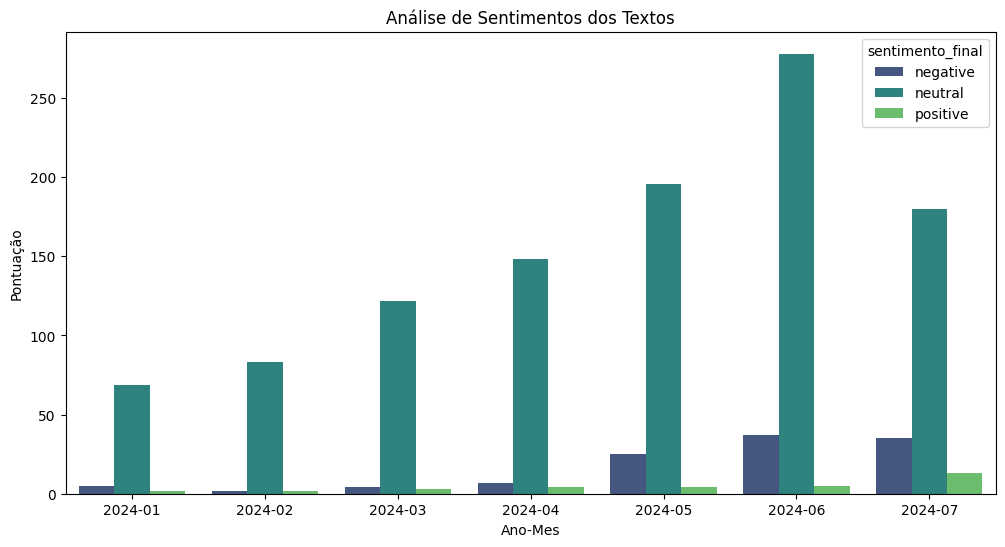

In [ ]:
### total base sentimentos

qtd_sentimentos = df.groupby(['Ano_Mes','sentimento_final'])["date_format"].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Ano_Mes', y='date_format', hue = 'sentimento_final', data=qtd_sentimentos, palette='viridis')
plt.title('Análise de Sentimentos dos Textos')
plt.xlabel('Ano-Mes')
plt.ylabel('Pontuação')
plt.show()

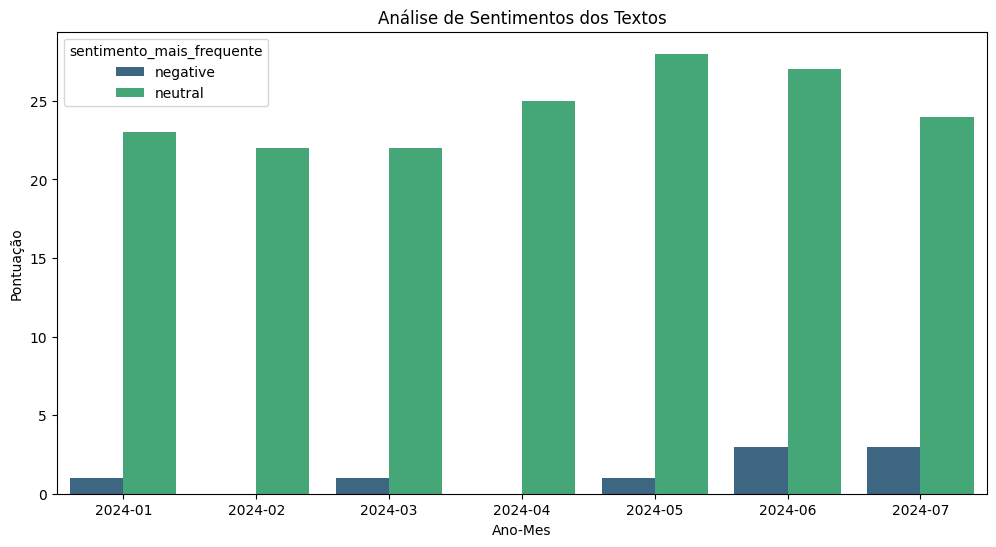

In [ ]:
# Adicionando títulos e rótulos
## sentimento resumido por dia

plt.figure(figsize=(12, 6))
sns.barplot(x='Ano_Mes', y='date_format', hue = 'sentimento_mais_frequente', data=df_final, palette='viridis')
plt.title('Análise de Sentimentos dos Textos')
plt.xlabel('Ano-Mes')
plt.ylabel('Pontuação')
plt.show()

In [ ]:

# Criar uma única string com todo o texto da coluna pré-processada
texto_combined = ' '.join(df['noticia_processada'])

# Criar um conjunto de stopwords
stopwords_pt = set([
    'a', 'o', 'e', 'de', 'do', 'da', 'que', 'em', 'um', 'para', 'com', 'não', 'na', 'no',
    'os', 'as', 'por', 'as', 'mais', 'mas', 'como', 'sobre', 'ou', 'mas', 'se', 'por', 'ele',
    'ela', 'ao', 'aos', 'às', 'aquela', 'aquele', 'aquilo', 'esse', 'essa', 'esses', 'essas',
    'muito', 'muita', 'são', 'é', 'tem', 'não', 'foi', 'ser', 'estar', 'há', 'vou', 'vai',
    'fui', 'este', 'esta', 'esses', 'essas'
])
# Gerar a nuvem de palavras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords_pt  # Adiciona stopwords à nuvem de palavras
).generate(texto_combined)

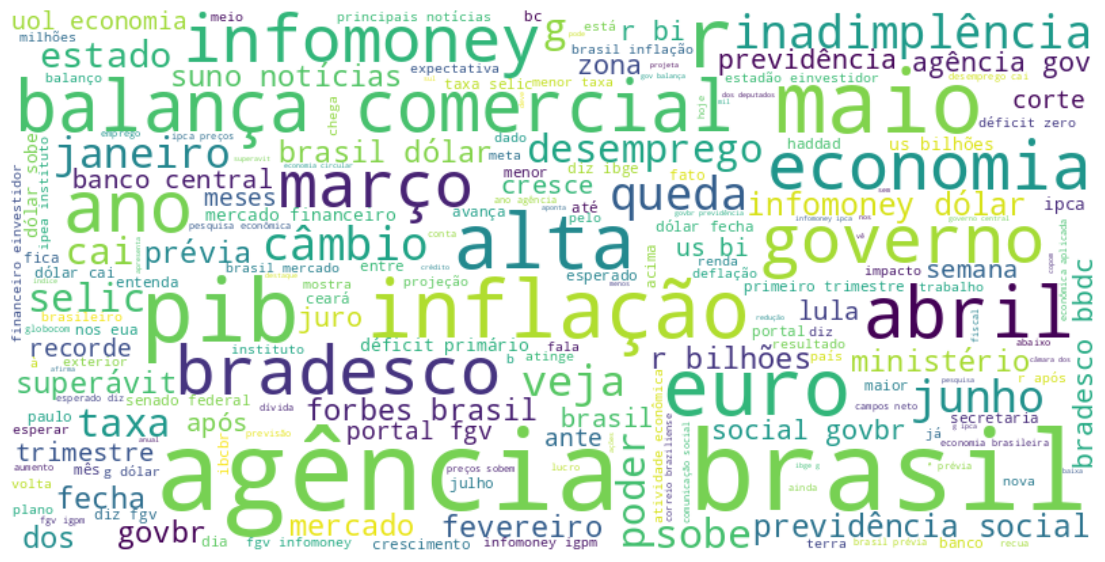

In [ ]:
# Exibir a nuvem de palavras
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()